## What are the most common comorbidities in our claims data?

What is the distribution of the number of comorbidities for people having at least one chronic condition of interest?

What is the combination for a given chronic condition (include Chi-square as part of presented information)

Denominator: People who have 2 or more chronic conditions 

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('../../data/reshaped_med.csv')

In [3]:
def count_comorbidities(group):
    count_df = pd.DataFrame()
    count_df['member_id'] = group.head(1)['member_id']
    count_df['num_comorbidities'] = group['total_conditions'].max() - 1
    return count_df

In [4]:
# Get rows with at least 1 condition
with_condition = data.loc[data['total_conditions'] > 0]

# Group by member ID and count comorbidities; 2 conditions = 1 comorbidity, etc.
comorbidity_count = with_condition.groupby('member_id', as_index=False).apply(count_comorbidities)

In [5]:
comorbidity_count.describe()

,num_comorbidities
count,5921.000000
mean,0.991555
std,1.208611
min,0.000000
25%,0.000000
50%,1.000000
75%,2.000000
max,7.000000


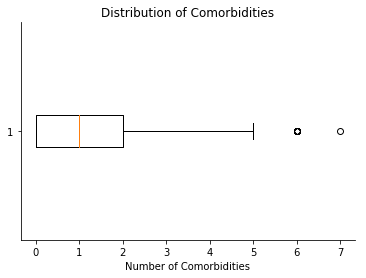

In [6]:
ax = plt.subplot()
ax.boxplot(comorbidity_count['num_comorbidities'], vert=False)
ax.set_xlabel('Number of Comorbidities')
ax.set_title('Distribution of Comorbidities')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

In [22]:
def combination(condition):
    # Get all rows with at least 2 conditions
    comorbid = data.loc[data['flag_comorbidity'] == 1]
    
    # Get rows with given condition
    with_condition = comorbid.loc[data['binary_' + condition] == 1]
    
    counts = with_condition.groupby('member_id', as_index=False).apply(count_conditions)
    return counts.sum(axis=0)

In [16]:
def count_conditions(group):
    counts = pd.DataFrame()
    
    counts['kidney'] = [1 if any(group['binary_kidney'] == 1) else 0]
    counts['mental_disorder'] = [1 if any(group['binary_mental_disorder'] == 1) else 0]
    counts['bp'] = [1 if any(group['binary_bp'] == 1) else 0]
    counts['cardiovascular'] = [1 if any(group['binary_cardiovascular'] == 1) else 0]
    counts['diabetes'] = [1 if any(group['binary_diabetes'] == 1) else 0]
    counts['obesity'] = [1 if any(group['binary_obesity'] == 1) else 0]
    counts['cancer'] = [1 if any(group['binary_cancer'] == 1) else 0]
    counts['musculoskeletal'] = [1 if any(group['binary_musculoskeletal'] == 1) else 0]
    counts['copd'] = [1 if any(group['binary_copd'] == 1) else 0]
    counts['cholesterol'] = [1 if any(group['binary_cholesterol'] == 1) else 0]

    return counts

In [27]:
counts = combination('bp')
counts

kidney              139
mental_disorder      53
bp                 2190
cardiovascular     1105
diabetes           1094
obesity             605
cancer              238
musculoskeletal     120
copd                245
cholesterol        1053
dtype: int64

In [38]:
comorbid = data.loc[data['flag_comorbidity'] == 1]
len(comorbid.index)

4242